In [2]:
%pylab inline
import scipy.sparse as sp
from scipy.linalg import hadamard as hadamard
from sympy import isprime as isprime
from math import gcd as GCD
from scipy.sparse import diags as sparse
from scipy.sparse.linalg import eigsh as eigval

Populating the interactive namespace from numpy and matplotlib


In [11]:
    "parameters of the system and operators"

    
    "Number to be decomposed"
    N=21
    
    "control and target registers size"
    L=math.ceil(math.log2(N))
    control_size=2**(2*L)
    target_size=2**L
    
    
    """
    superposition of dimension 2**2L x 2**2L, to be constructed only once.
    Avoided memorization of the H_2L Hadamard operator, since it's not sparse.
    control_superposition= H^2L |0>
    """  
    control_superposition=np.ones(control_size)/control_size
    
    print("qubits required= ",3*L)

qubits required=  15


In [12]:
def why_entanglement_entropy(k,Y,N):
    '''
    Returns the entanglement entropy up to the k-th computational step S_{k,r}
    It uses a lot of useless stuff
    Parameters
        ----------
        N:  Integer
            Number to be factorized
            
        Y : Integer 
            Randomly sampled in [2,N-1]. It's a coprime of N
            
        k: Integer
           Computational step
    '''
    
    size=2**k
    
    #nonzero diagonal elements
    nonzero=[(Y**m) %N for m in range(0,size)]
    
    #sparse reduced density matrix
    rho_k= sparse(  [nonzero.count(i)/size for i in range(size)] )
    
    eigvals,_= eigval(rho_k,k=size)
    return sum([-l*log2(l) for l in eigvals])

In [13]:
def entanglement_entropy(k,Y,N):
    '''
    Since density matrix has only few nonzero diagonal elements,
    u can check how many they're and compute directly eigenvalues
    '''
    if(k>2*ceil(log2(N))):
        raise ValueError("Illegal argument: "+str(k)+"th computational step does not make sense in a "+str(2*ceil(log2(N)))+" control register")
    
    size=2**k
    
    #nonzero diagonal elements
    nonzero=[]
    nonzero.append(1)
    m=1
    while(((Y**m) % N!=1) and (m<size)):
        nonzero.append((Y**m) % N)
        m+=1

    #nonzero=[(Y**m) %N for m in range(0,size)]
    
    #order
    r=len(nonzero)
    
    q=int(floor(size/r))
    c=size-q*r

    #eigvals=[nonzero.count(i)*1.0/size for i in nonzero[0:order]]
    #return -sum([l*log2(l) for l in eigvals])
    
    return -(r-c)*q*1.0/size * log2(q/size)-c*(q+1)/size * log2((q+1)/size)

In [14]:
def order_finding(N,Y):
    """
        Find the order of Y module N using quantum computation
        Parameters
        ----------
        N:  Integer
            Number to be factorized
            
        Y : Integer 
            Randomly sampled in [2,N-1]. It's a coprime of N
            
            
    """
    return 1

## ENTANGLEMENT ENTROPY AS A FUNCTION OF COMPUTATIONAL STEP FOR FIXED N##

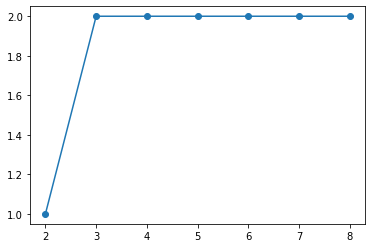

In [15]:
'''
tests

k=2
#print(entanglement_entropy(k,13,15))

r=4 #order
q=floor(2**k/r) #number of complete sequences
c=2**k-q*r #elements of the truncated last sequence

expected=-(r-c)*q/2**k * log2(q/2**k)-c*(q+1)/2**k * log2((q+1)/2**k)

#in case there's no complete sequence, the first term is 0 
if(q==0): expected=-c*(q+1)/2**k * log2((q+1)/2**k)

#print(expected)

'''

##Figure 3 emulation: N=15, Y=13

L=int(ceil(log2(15)))
res=[]
for k in range(1,2*L):
    res.append(entanglement_entropy(k,13,15))
    
plot(range(2,2*L+1),res,'-o')

## HEATMAP##

In [16]:
def prime_power(N):
    """
            Check if the argument N is a prime power, i.e. exist p prime and i integer s.t. p**i=N
            If the argument is is a prime power p is returned, otherwise 1 is returned
            Parameters
            ----------
            N:  Integer
            Candidate prime power

    """
    
    roof=int(ceil(math.log2(N))+1) #integer right after log2(N)
    
    roots=[(N**(1./i)) for i in range(2,roof)] 
    
    for (i,element) in enumerate(roots):
        if (element.is_integer() and isprime(int(element))): #then element**(i+2)=N
            return int(element)
    return 1
       
def Lfy(N):
    return int(ceil(log2(N)))

def heatmap_data():
    #odd numbers which are nor primes nor prime powers in [0,2000]: list of Ns
    candidates=[(i*2)+1 for i in range(7,1000) if( (not isprime(2*i+1)) and (prime_power(2*i+1)==1) ) ]
    return [[(N,Y,entanglement_entropy(2*Lfy(N),Y,N)) for Y in range(2,N) if(GCD(Y,N)==1)] for N in candidates]

In [17]:
%%time
data=heatmap_data()
#30 entries: 16.4 ms,   60: 70ms, 120:  330, 250: 3.34, 500: 46 s, 1000: 13 1/2 min

CPU times: user 13min 22s, sys: 341 ms, total: 13min 22s
Wall time: 13min 22s


In [3]:
import pickle
#with open("heatmap.txt", "wb") as fp:
#    pickle.dump(data, fp)
    
with open("heatmap.txt", "rb") as fp:
    newdata = pickle.load(fp)
    
N_axis=array([x[0] for j in range(len(newdata)) for x in newdata[j]])
Y_axis=array([x[1] for j in range(len(newdata)) for x in newdata[j]])
S_axis=array([x[2] for j in range(len(newdata)) for x in newdata[j]])

In [ ]:
down,up=[0,len(N_axis)]
plt.scatter(N_axis[down:up], S_axis[down:up], c=Y_axis[down:up], marker='s',cmap='binary' ,s=.5)
plt.xlabel('N')
plt.ylabel('S')
plt.show()

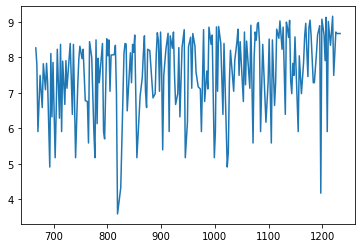

In [27]:
S_max=[np.max(newdata[i],axis=0)[2] for i in range(len(newdata))]
N_max=[newdata[i][0][0] for i in range(len(newdata))]

plot(N_max[200:400], S_max[200:400])

## COMPLETE ALGORITHM WITH CLASSICAL PART##

In [ ]:
def shor(N):
    """
            Find a non trivial divisor of N
            Parameters
            ----------
            N:  Integer
                Number to be factorized

    """

    if(N%2==0): return 2
    if isprime(N):
        print(N," is a prime number")
        return 1
    
    p=prime_power(N)
    if(p!=1): return p
    
    #random extraction
    
    #candidates=list(range(3,N))
    #Y=random.choice(candidates)
    
    Y=randint(2,N)
    used=[]
    while 1:
        a=GCD(Y,N)
        if (a>1): return a
        
        #N,Y coprimes
        
        r=order_finding(N,Y)
        if(r%2==0):
            s=r/2.
            
            factor=(Y**s+1% N)
            if(factor!=0):
                a=GCD(factor,N)
                if ( a>1 ): return a
                else: return GCD(Y**s-1 %N,N)
        
        #this Y is stored as used and a new Y is extracted. The whole while() is repeated
        used.append(Y)
        Y=randint(2,N)
        while(Y in used):
            Y=randint(2,N)
            
        #candidates.remove(Y)
        #Y=random.choice(candidates)

In [ ]:
len(bin(1024)[2:])

In [7]:
candidates=[(i*2)+1 for i in range(7,1000) if( (not isprime(2*i+1)) and (prime_power(2*i+1)==1) ) ]